*이 파일에는 model2와 model3를 구현

<h2>model1 - ResNet50을 이용

- pretrained_ResNet50.ipynb
- ResNet50모델을 따로 학습하진 않고  feature extract 하여 이를 kmeansclustering
- 결과물이 좋지 x (실루엣계수가 0.1에서 머무름)
- Imagenet의 이미지들을 통해 학습한 해당 모델이 카페 이미지에는 적절치 않다고 생각




<h2>model2 - vgg16_places_365
 
 
 - 1.8million개의 scene image를 학습한 pretrained 모델
 - github에서 다운받아 사용할 수 있었음
 - 1번과 마찬가지로 따로 더 학습하진 않고 feature extrac해 이를 kmeansclustering
 - 실루엣계수가 1번보다 훨씬 향상됨을 볼 수 있었음





<h2>model3 - vgg16_places_365 + 차원축소(pca)


 - 교수님께 1번모델의 어려움을 질문했을 때 차원축소 피드백을 받았음
 - 2번모델로 나온 feature를 pca 차원축소함 (365dim >2dim)
 - 실루엣계수가 0.4이상이 나올 정도로 초반의 1번모델보다 훨씬 향상됨



In [35]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12987884812226491842]

In [36]:
%pylab inline
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
#from cv2 import imread
#from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
# To stop potential randomness
#seed = 128
#rng = np.random.RandomState(seed)

<h1> mount

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%cd "/content/drive/My Drive/DL/teamproject"

/content/drive/My Drive/DL/teamproject


<h1> data 불러오기 - 경로 설정

In [39]:
# # Now set the working path of your data, so that you can access it later on.
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, 'DL_data/data/')

In [40]:
#!unzip -qq "/content/drive/My Drive/DL/teamproject/DL_data.zip"

In [41]:
data_dir="/content/drive/My Drive/DL/teamproject/"

<h1> data 불러오기 - imagedatagenerator

In [69]:
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(data_dir,color_mode="rgb",class_mode="input",
        target_size=(224,224), batch_size=256)


Found 10143 images belonging to 5 classes.


In [70]:
filenames = train_generator.filenames
nb_samples = len(filenames)
#predict = model.predict_generator(test_generator,nb_samples)#

In [43]:
!pwd

/content/drive/My Drive/DL/teamproject


In [44]:
#pip install keras-models

<h2> Pretrained model- vgg16_places_365 load



In [57]:
from keras import backend as K
from keras.layers import Input
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.layers import Conv2D
from keras.regularizers import l2
from keras.layers.core import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils import layer_utils
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

In [60]:
#!pip install keras_applications

     |████████████████████████████████| 51kB 2.0MB/s 


In [61]:
from google.colab import files
src = list(files.upload().values())[0]
open('file1.py','wb').write(src)
import vgg16_places_365

Saving vgg16_places_365.py to vgg16_places_365 (4).py


In [62]:
from vgg16_places_365 import VGG16_Places365

In [63]:
Place365_model = VGG16_Places365(weights='places')

543096832/543085444 [==============================] - 25s 0us/step


In [67]:
Place365_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7efe0fdb2e10>>

<h1>Feature Extraction Using Place365-VGG

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
batch_size=256
Place365_feature = Place365_model.predict_generator(train_generator,nb_samples)


In [72]:
Place365_feature.shape

(10143, 365)

In [75]:
#feature들 저장(feature extract 오래걸려서)
import pickle
with open('Plade365_feature.pickle', 'wb') as f:
    pickle.dump(Place365_feature, f, pickle.HIGHEST_PROTOCOL)

<h1>kmeans clustering 수행


<h1> 최적의 k 값 찾기 - 실루엣계수와 엘보우 기법으로



In [90]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil=[]
distortions = []
kmax=15
labels_total=[]
for k in range(2, kmax+1):
    kmeans = KMeans(n_jobs=1,n_clusters = k,n_init=20).fit(Place365_feature)
    labels = kmeans.labels_
    labels_total.append(labels)
    # save the model
    pickle.dump(kmeans, open("km"+str(k)+".pkl", "wb"))
    print(k)
    sil.append(silhouette_score(Place365_feature, labels, metric = 'euclidean'))
    distortions.append(kmeans.inertia_)

2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [89]:
labels.shape

(10143,)

Text(0.5, 1.0, 'The Sillhouette Score showing the optimal k')

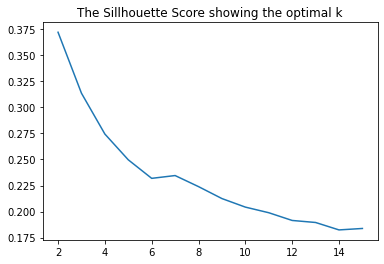

In [79]:
import matplotlib.pyplot as plt
k=list(range(2, kmax+1))
plt.plot(k, sil)
plt.title('The Sillhouette Score showing the optimal k')

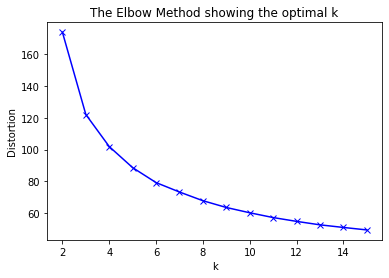

In [143]:
k=list(range(2, kmax+1))
plt.plot(k, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<h1> filename과 label 저장

In [92]:
import pandas as pd
result=pd.DataFrame({'filename':filenames})

In [100]:
for k in range(len(labels_total)):
  temp='pred_'+str(k+2)
  result[temp]=labels_total[k]

In [101]:
result.head()

,filename,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15
0,data/cafe_1001_0.jpg,1,0,0,0,2,5,7,2,0,8,4,0,3,14
1,data/cafe_1001_1.jpg,1,1,1,4,4,2,0,0,4,0,8,7,6,13
2,data/cafe_1001_10.jpg,1,0,2,2,5,0,5,7,7,1,7,1,8,4
3,data/cafe_1001_11.jpg,1,0,0,4,4,2,0,3,7,4,3,10,1,11
4,data/cafe_1001_2.jpg,1,1,1,3,0,6,3,4,3,10,8,5,7,5


In [102]:
result.to_csv(r'Place365_clustering.csv')

<h1>model3 - extracted feature를 PCA 차원축소 후 clustering


In [131]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcaComponents = pca.fit_transform(Place365_feature)

In [132]:
pcaComponents.shape

(10143, 2)

In [133]:
sil

[0.3721272,
 0.31361726,
 0.2744414,
 0.24967763,
 0.23194459,
 0.23460174,
 0.22417024,
 0.2124942,
 0.20416279,
 0.19933525,
 0.19160743,
 0.18952398,
 0.18283385,
 0.18568613]

In [ ]:
#kmeans clustering 수행
from sklearn.metrics import silhouette_samples, silhouette_score
sil_2=[]
distortions_2 = []
kmax=15
labels_total_2=[]
for k in range(2, kmax+1):
    kmeans = KMeans(n_jobs=1,n_clusters = k,n_init=20).fit(pcaComponents)
    labels = kmeans.labels_
    labels_total_2.append(labels)
    # save the model
    pickle.dump(kmeans, open("km"+str(k)+".pkl", "wb"))
    print(k)
    sil_2.append(silhouette_score(pcaComponents, labels, metric = 'euclidean'))
    distortions_2.append(kmeans.inertia_)

Text(0.5, 1.0, 'The Sillhouette Score showing the optimal k')

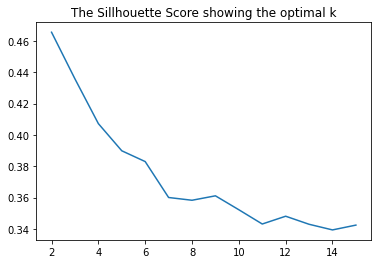

In [136]:
import matplotlib.pyplot as plt
k=list(range(2, kmax+1))
plt.plot(k, sil_2)
plt.title('The Sillhouette Score showing the optimal k')

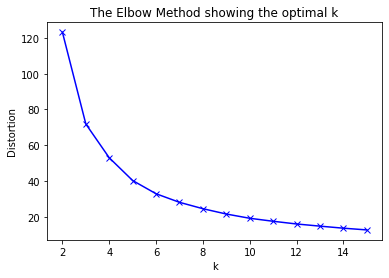

In [145]:

plt.plot(k, distortions_2, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [138]:
#파일명과 label 저장
import pandas as pd
result2=pd.DataFrame({'filename':filenames})
for k in range(len(labels_total_2)):
  temp='pred_'+str(k+2)
  result2[temp]=labels_total_2[k]

In [139]:
result2.to_csv(r'Place365_pca_clustering.csv')